# 和 Tree SHAP有关的知识点


## SHAP

摘自 https://christophm.github.io/interpretable-ml-book

## The Shapley Value

From coalitional game theory.

已知有p个人合作赚了钱，如果我们有一个函数$val$能计算p个人中任意子集所能产出的钱，那么应该如何确定一个分钱的函数$\phi$， 使得$\phi$函数对所有人而言是公平的？

思路：我们想知道应该分给第$j$个人多少钱，我们可以计算$j$在与不在的所有情况下所能获得的钱的差值。

也就是对所有的$S \subset \{1, ..., p\} \backslash \{j\}$， 

我们计算 
$val(S \cup \{j\}) - val(S)$

将这个差值取均值之后，我们就能得到对$j$的Shapley value：

$$\phi_j(val) = \frac{1}{p}\sum_{S \subset \{1, ..., p\}\backslash \{j\}} \frac{ (val(S\cup\{j\})-val(S)) }{ C_{p-1}^{|S|}}$$


$$= \sum_{S \subset \{1, ..., p\}\backslash \{j\}} \frac{|S|!(p-|S|-1)!}{p!} (val(S\cup\{j\})-val(S))$$

## SHapley Additive exPlanations

SHAP (SHapley Additive exPlanations) is a method to explain individual predictions. SHAP is based on the game theoretically optimal Shapley Values.

SHAP is an additive feature attribution method.

$$g(z')=\phi_0 + \sum_{j=1}^M \phi_j z'_j$$

where $g$ is the explanation model and $z' \in \{0,1\}^M$ is the coalition vector, $M$ is the maximum coalition size and $\phi_j \in R$ is the feature attribution of a feature $j$(Shapey values).

### KernelSHAP

KernelSHAP estimates for an instance x the contributions of each feature value to the prediction. KernelSHAP consists of 5 steps:

1. Sample coalitions $z'_k \in \{0,1\}^M$
2. Get prediction for each $z'_k$ by first converting $z'_k$ to the original feature space and then applying model $\hat{f}(h_x(z'_k))$.
3. Compute weight for each $z'_k$ with the SHAP kernel.
4. Fit weighted linear model.
5. Return Shapley values $\phi_k$, the coefficients.

where $h_x$ is a function that maps the coalitions to a (random)instance.
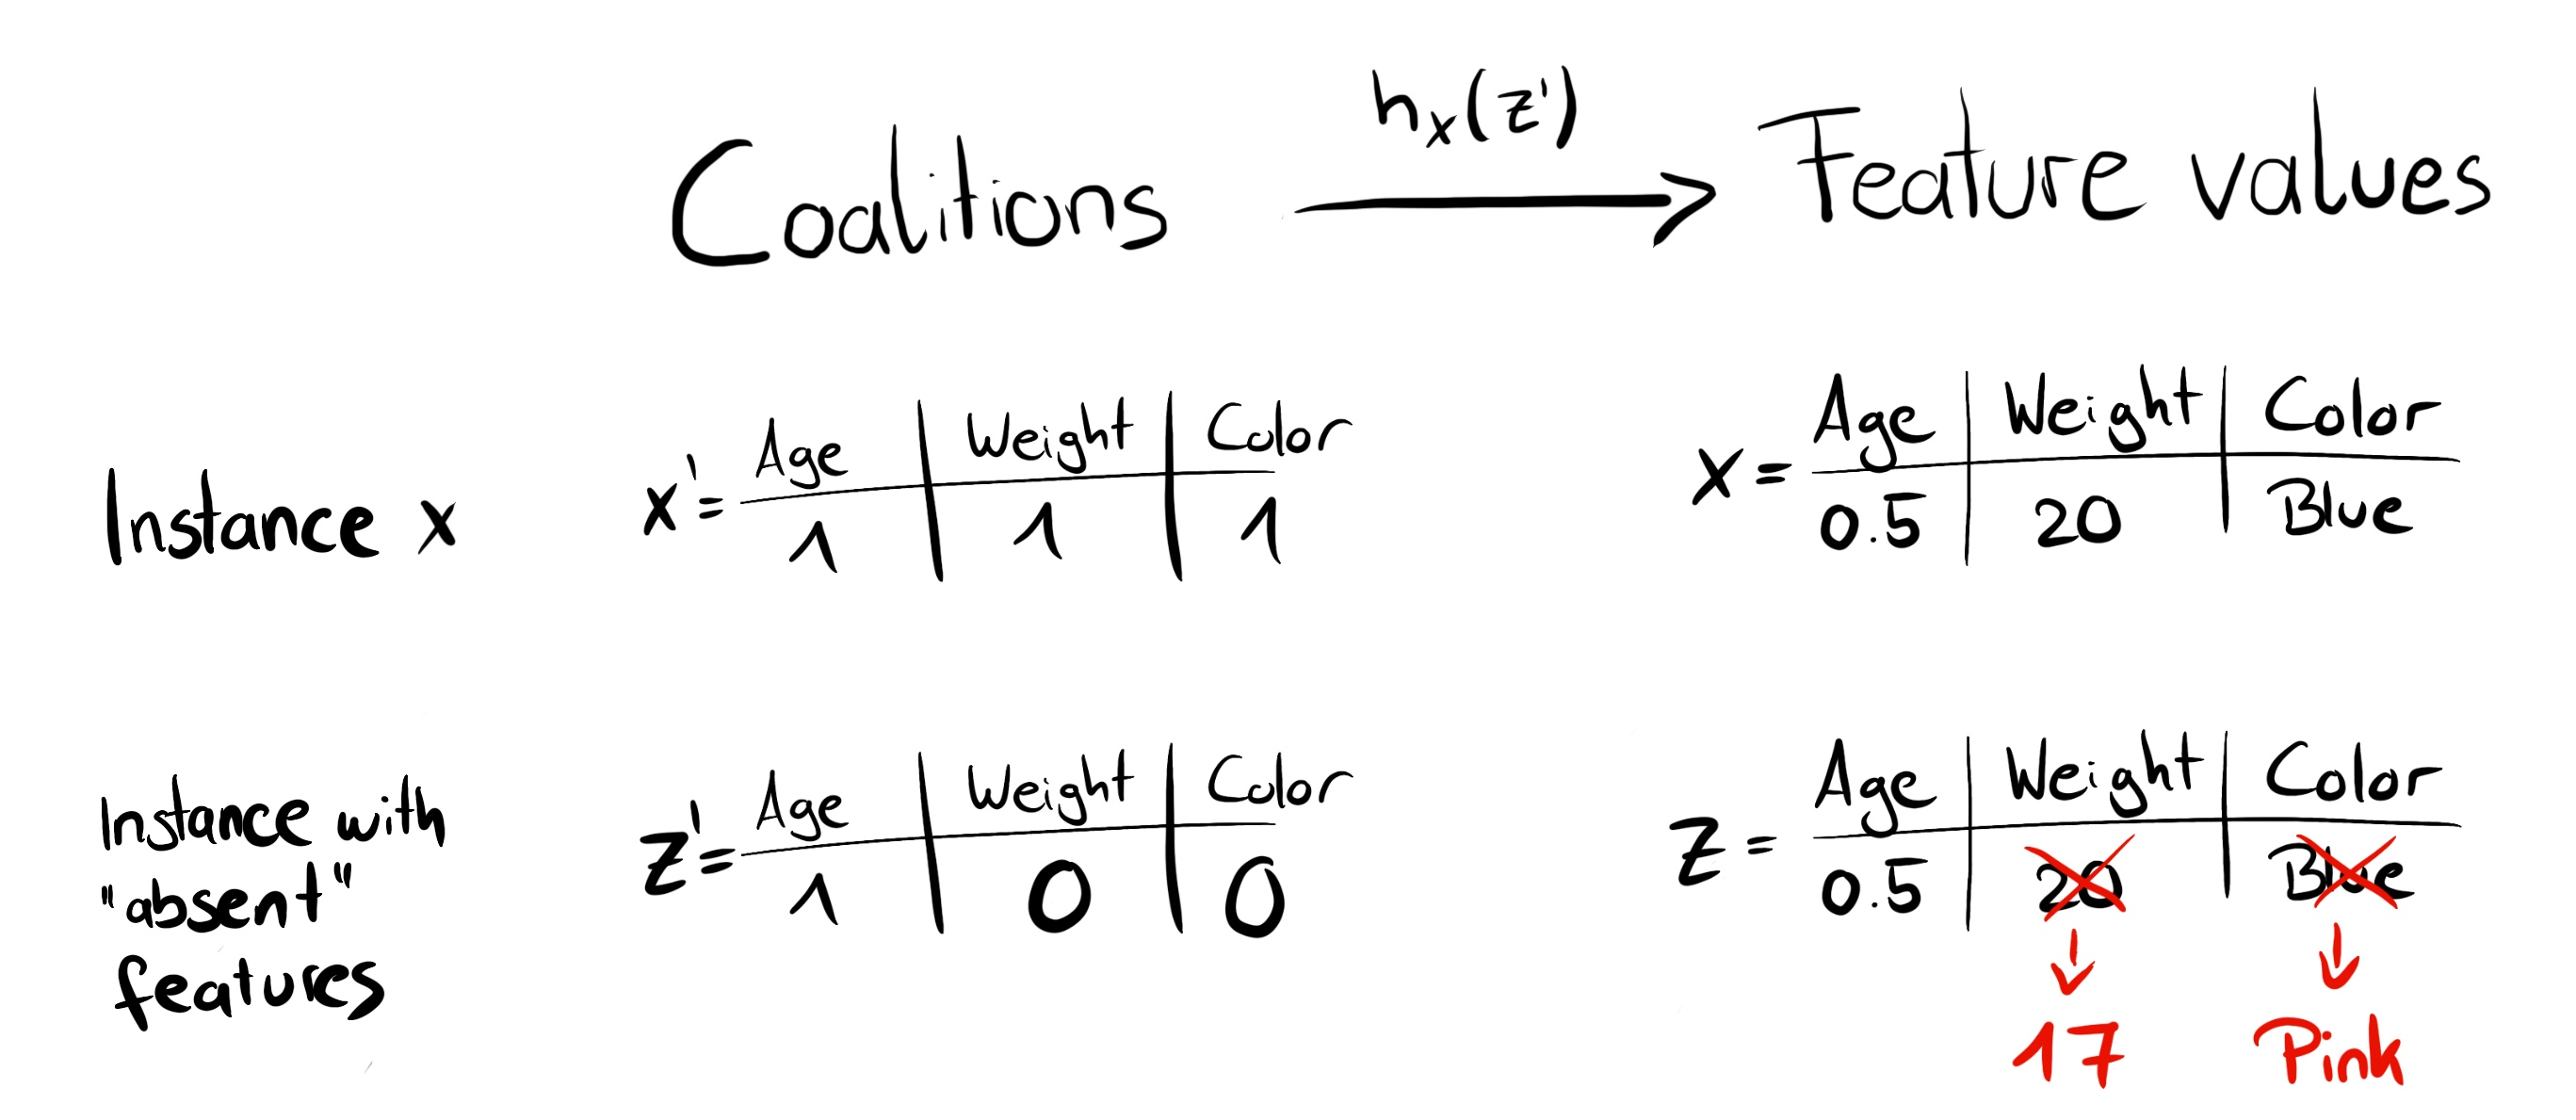

### 训练model g

We build the linear model 
$$g(z')=\phi_0 + \sum_{j=1}^M \phi_j z'_j$$

We define the loss function
$$L(\hat{f}, g, \pi_x)= \sum_{z' \in Z}[\hat{f}(h_x(z'))-g(z')]^2 \pi_x(z')$$

where the weights $$\pi_x(z') = \frac{M-1}{C_M^{|z'|}|z'|(M-|z'|)}$$
$M$ is the maximum coalition size.

$Z$ is the training data.

## TreeSHAP

https://xgboost.readthedocs.io/en/latest/tutorials/model.html

XGBoost

$\text{obj} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i)$

The first question we want to ask: what are the parameters of trees? 
You can find that what we need to learn are those functions $f_i$
, each containing the structure of the tree and the leaf scores. Learning tree structure is much harder than traditional optimization problem where you can simply take the gradient. It is intractable to learn all the trees at once. Instead, we use an additive strategy: fix what we have learned, and add one new tree at a time. We write the prediction value at step $t$ as $\hat{y}_i^{(t)}$ 
. Then we have

$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

It remains to ask: which tree do we want at each step? A natural thing is to add the one that optimizes our objective.

\begin{split}\text{obj}^{(t)} & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + \mathrm{constant}\end{split}

If we consider using mean squared error (MSE) as our loss function, the objective becomes


$$\begin{split}\text{obj}^{(t)} & = \sum_{i=1}^n (y_i - (\hat{y}_i^{(t-1)} + f_t(x_i)))^2 + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n [2(\hat{y}_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)^2] + \Omega(f_t) + \mathrm{constant}\end{split}$$

we take the Taylor expansion of the loss function up to the second order:

$$\text{obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}$$

where $g_i$ and $h_i$ are defined as 

$$\begin{split}g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})\end{split}$$

After we remove all the constants, the specific objective at step $t$ becomes

 $$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$$
 
